# Fluorescence decay forward model

A forward model is a model that computes for a set of input parameters a model of the experimental data. In fluorescence decay analysis, model parameters, e.g., fluorescence lifetimes and corresponding amplitudes are transformed to fluorescence decay curves. These fluorescence decay curves are perturbed by additional nuisances. For instance, the presence of a non-fluorescent background. Additionally, fluorescence decay curves need to be convolved with the instrument response functions (IRFs). Parameters that are not of interest but that are a necessary part of the forward model are nuisance parameters. In a fluorescence decay, a nuisance parameter can be the fraction the non-fluorescent background or a shift of the IRF relative to the fluorescence decay. An (incomplete) list of nuisances sources and fluorescence decay distortions are the

1. Convolution with instrument
2. Pile-up single photon counting electronics
3. Differential non-linearities
4. Background (either constant or patterned)

Details on distortions and nuisances in time-correlation single photon counting (TCSPC) are described [elsewhere](decay_distortions.ipynb) <cite data-cite="o2012time,becker_advanced_2005">O'Connor and Phillps(1984), Becker(2005)</cite>. This section focuses on practical aspects on implementing a simple forward model for fluorescence decays with `IMP.bff` including the scoring by an [objective function](decay_objective_function.ipynb) that can be used for optimization and sampling over parameters and is also implemented in the interactive data analysis software [ChiSurf](decay_chisurf.ipynb).

## Data reading

The forward model takes the following experimental data as an input for nuisances

1. Instrument response function (IRF / Prompt)
2. Optional linearization table for the instrument (here called whitelight).

for computing model fluorescence decay curves.

In a FRET experiment that quantifies the quenching of a donor fluorophore due to FRET, the following experiments are input parameters of the scoring function

1. Model fluorescence decay
2. Fluorescence decay of the donor in the absence of FRET (Donor)
3. Fluorescence decay of the donor in the presence of FRET

For instance, the example data set does not contain information on the time-resolution (i.e., bin width of the fluorescence decay histogram). Thus, the TCSPC channel width is multiplied with the time-resolution of the decay histogram.

In [1]:
# Import use libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import IMP
import IMP.bff

In [2]:
dt = 0.0141 # time resolution (bin width of decay histogram)
fns = {
    "lintable": IMP.bff.get_example_path("spectroscopy/hgbp1/eTCSPC_whitelight.txt"),
    "irf": IMP.bff.get_example_path("spectroscopy/hgbp1/eTCSPC_Prompt.txt"),
    "donor": IMP.bff.get_example_path("spectroscopy/hgbp1/eTCSPC_Donor.txt"),
    "fret": IMP.bff.get_example_path("spectroscopy/hgbp1/eTCSPC_FRET.txt")
}
data = dict()
for key in fns:
    df = pd.read_csv(fns[key], skiprows=6, sep='\t')
    data[key] = IMP.bff.DecayCurve(x=df['Chan'] * dt, y=df['Data'])

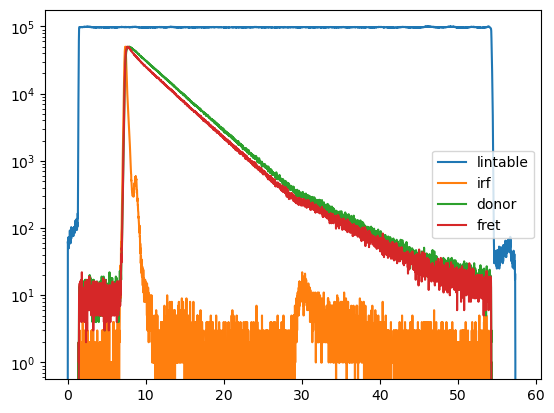

In [3]:
for key in data:
    d = data[key]
    plt.semilogy(d.x, d.y, label=key)
plt.legend()
plt.show()

The faster decay of the donor fluorescence is a visible hallmark of FRET. Details on how such data can be visualized and quantified graphically are given [here](decay_curves.ipynb#FRET-induced-donor-decay). 

## Fluorescence decay forward model

### Output fluorescence decay

First, we create a `IMP.bff.DecayCurve` decay object as an output for the forward model. 

In [4]:
decay = IMP.bff.DecayCurve(x=data["irf"].x)
decay.sum()

0.0

We use, the experimental IRF as a template. This assures that the number of TCSPC channels of the output fluorescence decay model matches the number of channels of the IRF. We do not initialize the counts of the output object.

### Lifetime handler

Next, we create a `IMP.bff.DecayLifetimeHandler` object that handles "lifetime spectra". A "lifetime spectrum" is a set of relaxation times with corresponding amplitudes.

In [5]:
lifetime_spectrum = np.array(
    [
        (0.8, 4.0), # pair of amplitude and lifetime
        (0.2, 2.0)
    ]
)
lifetime_settings = {
    'lifetime_spectrum': lifetime_spectrum.flatten(),
    'abs_lifetime_spectrum': False,   # True -> take abs of liftime spectrum
    'use_amplitude_threshold': False, # True -> discriminate lifetimes below threshold
    'amplitude_threshold': 0.0
}
lh = IMP.bff.DecayLifetimeHandler(**lifetime_settings)

### Convolution


`IMP.bff.DecayConvolution` objects handle convolutions. Alternative routines described in more details in the [examples](../../auto_examples/spectroscopy/plot_convolution_routines.ipynb).

In [14]:
convolution_settings = {
    "lifetime_handler": lh,
    "instrument_response_function": data["irf"],
    "convolution_method": IMP.bff.DecayConvolution.FAST,
    "excitation_period": 100,
    "irf_shift_channels": 0.0,
    "irf_background_counts": 0.0,
    "start": 100, "stop": 3800
}

The `IMP.bff.DecayConvolution` is called with a decay object.

In [15]:
dc = IMP.bff.DecayConvolution(**convolution_settings)
dc(decay)

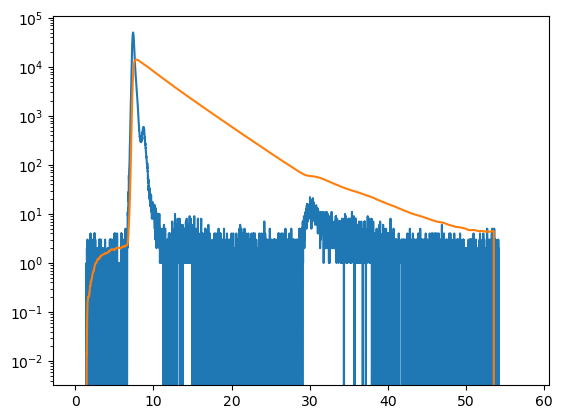

In [16]:
plt.semilogy(data["irf"].x, data["irf"].y)
plt.semilogy(decay.x, decay.y)
plt.show()

### Pile up



Pile up changes the change of fluorescence decay curves recorded by TCSPC. The cause of pile-up and corrections are described in <cite data-cite="o2012time,becker_advanced_2005"></cite>. Other examples on pile up are given in the [examples](../../auto_examples/spectroscopy/plot_pile_up.ipynb). Pile up is added to a model as follows. 

In [17]:
pile_kwargs = {
    "pile_up_model": "coates",
    "repetition_rate": 80.0, # Rep. rate in MHz
    "instrument_dead_time": 120.0, # Dead time of the instrument
    "start": 0, # starting channel (index)
    "stop": -1, # stop channel (index)
    "active": True # If true applies pile up to model
}
dp = IMP.bff.DecayPileup(decay, **pile_kwargs)

Here, the time to record the decay (the acquisition) is used (together with the dead time of the instrument) to perturb the decay by pile up. The acquisition time of the (experimental) decay is an attribute of the [decay](decay_curves.ipynb#Fluorescence-decay-curve-attributes). 

In [18]:
y1 = decay.y
dp.add(decay)
y2 = decay.y

For the given instrumental dead time, the acquisition time of the decay, and the number of photons in the decay the effect of pile up is clearly visible in the model.

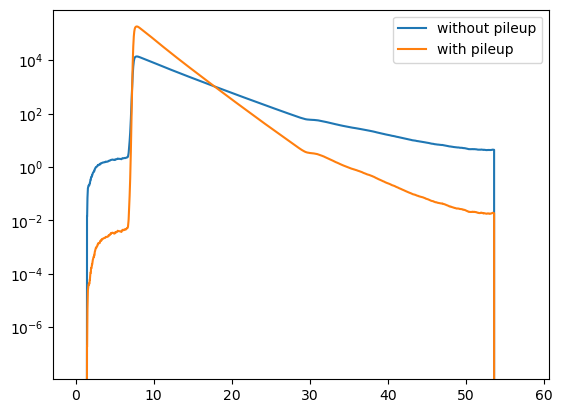

In [19]:
plt.semilogy(decay.x, y1, label="without pileup")
plt.semilogy(decay.x, y2, label="with pileup")
plt.legend()
plt.show()

### Background
Often a fluorescence decay is perturbed by a background. The background can is either patterned (non-constant) or constant. In single molecule spectroscopy (SMS) the background often stems from scattered light of the sample and the pattern of the background follows closely the instrument response function. In such a case a patterned background should be used. In case of ensemble measurement the fraction of scattered light is usually low and the background originates from the dark counts of the detector. In first approximation the dark counts are uniformly distributed with respect to the laser pulse (constant background).

Independent of the background type a background can be added to a decay curve as follows.

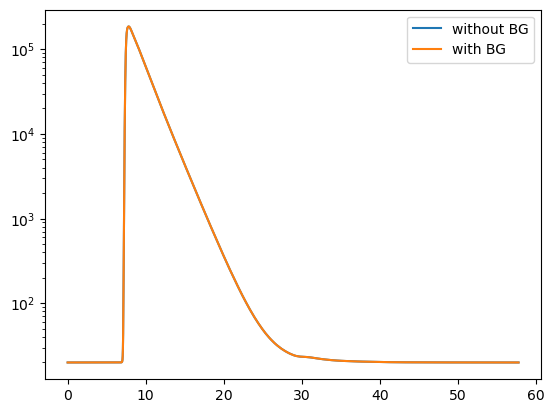

In [20]:
bg = IMP.bff.DecayPattern(20.0) # Constant background
bg.add(decay)
plt.semilogy(decay.x, decay.y, label="without BG")
plt.semilogy(decay.x, decay.y, label="with BG")
plt.legend()
plt.show()

For more details take a look at the unit tests.

### Differential non linearities
Fluorescence decays can be perturbed by differential non linearities (DNLs). Light that is not correlated to the excitation pulse should result in evenly distributed photons in the detection window. A correction for DNLs can be measured using uncorrelated light. A model fluorescence decay is perturbed by DNLs by multiplying a normalized uncorrelated light measurement with the decay. The experimental measured DNL is noisy. To minimize the effect of this noise the measured DNL is smoothed. `IMP.bff.DecayLinearization`, the class that handles DNLs in `IMP.bff`, compute a simple moving average filter on the data using `IMP.bff.DecayCurve.apply_simple_moving_average` and applies DNLs to a `IMP.bff.DecayCurve` when `IMP.bff.DecayLinearization.add` is called.

In [25]:
lin_start, lin_stop = 110, -1
dnl = IMP.bff.DecayLinearization(
    data["lintable"],
    start=lin_start, stop=lin_stop, n_window=20
)
print(dnl.get_stop(data["lintable"]))
print(dnl.get_stop())

lt = dnl.get_linearization_table()
noisy = np.array(data["lintable"].y)
n2 = noisy / np.mean(noisy[lin_start: lin_stop])

4096
18446744073709551615


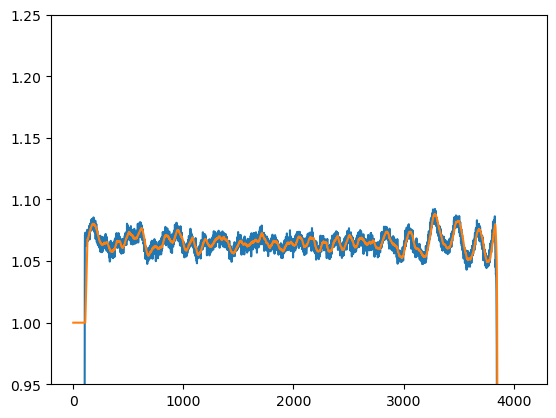

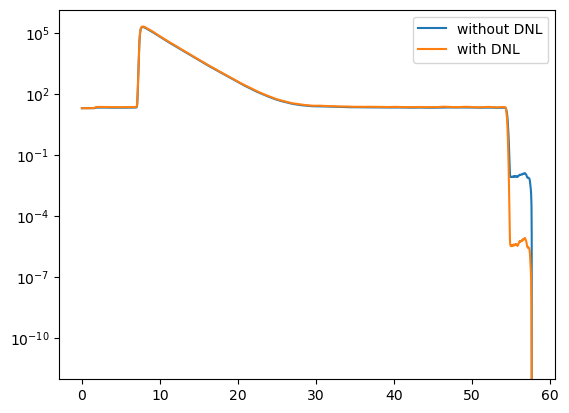

In [26]:
plt.plot(n2)
plt.plot(lt.y)
plt.ylim([0.95, 1.25])
plt.show()

y1 = decay.y
dnl.add(decay)
y2 = decay.y

plt.semilogy(decay.x, y1, label="without DNL")
plt.semilogy(decay.x, y2, label="with DNL")
plt.legend()
plt.show()

## Scoring

A forward model is scored by the data using a noise model. In single photon counting the data noise depends on the number of registered photons.

In [27]:
number_of_photons = 500

x = decay.x
y = decay.y
y /= np.sum(y)
y *= number_of_photons
y_noise = np.random.poisson(y)

decay_noisy = IMP.bff.DecayCurve(x, y_noise)

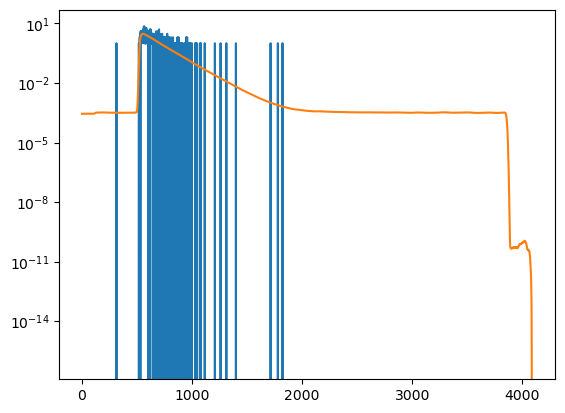

In [28]:
plt.semilogy(y_noise)
plt.semilogy(y)
plt.show()

## Scale to data

The score measures the disagreement between the model and the data. Often models are not scaled to the data - the number of photons of the model mismatches the number of photons of the data. `IMP.bff.DecayScale` objects handle the scaling of model decays to the data. 

In [29]:
decay_scale_kwargs = {
    "start": 110,
    "stop": 1500,
    "constant_background": 0.0,
    "active": True,
    "blank_outside": True
}

dsc = IMP.bff.DecayScale(
    decay_noisy, 
    start=110, 
    stop=1500
)
dsc.add(decay)

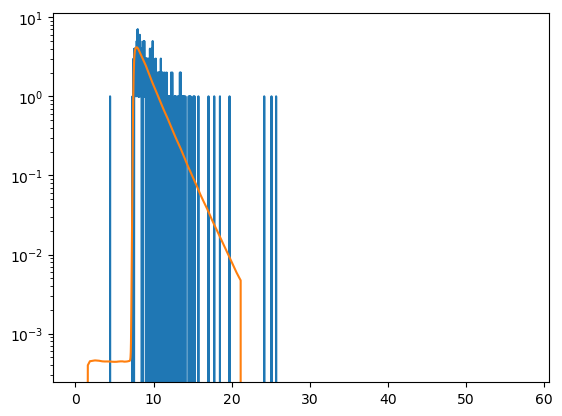

Sum(data): 521.0
Sum(model): 695.8849125870682


In [30]:
plt.semilogy(decay_noisy.x, decay_noisy.y)
plt.semilogy(decay.x, decay.y)
plt.show()
print("Sum(data):", decay_noisy.y.sum())
print("Sum(model):", decay.y.sum())

## Score

`IMP.bff.DecayScore` scores a forward model by the data in a certain time window range using a certain noise model.

In [31]:
score_kw = {
    "model": decay,
    "data": decay_noisy,
    "score_type": "sswr", #poisson, pearson, gauss, cnp, sswr (sum of weighte squared residuals)
    "start": 110,
    "stop": 1600
}
decay_score = IMP.bff.DecayScore(**score_kw)
score = decay_score.get_score()
n_ch = score_kw["stop"] - score_kw["start"]
score_r = score / n_ch
print("Score:", score)
print("Reduced score:", score_r)

Score: 422.40996475213507
Reduced score: 0.2834966206390168
